In [1]:
import cv2
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt

In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os

def compute_and_save_ela(input_dir, output_dir, jpeg_quality=95, amplify_factor=20):
    """
    Computes and saves ELA maps for all images in the given directory.
    
    Parameters:
        input_dir (str): Directory containing the original images.
        output_dir (str): Directory to save the ELA maps.
        jpeg_quality (int): Quality level for JPEG recompression (default is 95).
        amplify_factor (int): Factor to amplify differences in ELA maps (default is 20).
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    
    for root, _, files in os.walk(input_dir):
        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                input_path = os.path.join(root, file_name)
                relative_path = os.path.relpath(root, input_dir)
                output_path = os.path.join(output_dir, relative_path)
                
                os.makedirs(output_path, exist_ok=True)
                
                try:
                    # Open the original image
                    img = Image.open(input_path).convert('RGB')
                    
                    # Save as a high-quality JPEG to recompress
                    compressed_path = os.path.join(output_path, f"compressed_temp.jpeg")
                    img.save(compressed_path, 'JPEG', quality=jpeg_quality)
                    
                    # Reopen the recompressed image
                    compressed_img = Image.open(compressed_path)
                    
                    # Compute ELA map
                    ela_map = ImageChops.difference(img, compressed_img)
                    
                    # Amplify the differences
                    ela_map = ImageEnhance.Brightness(ela_map).enhance(amplify_factor)
                    
                    # Save the ELA map
                    ela_map.save(os.path.join(output_path, file_name))
                    
                    # Cleanup temporary file
                    os.remove(compressed_path)
                    
                    print(f"ELA saved: {os.path.join(output_path, file_name)}")
                    
                except Exception as e:
                    print(f"Failed to process {input_path}: {e}")

# Input and output directories
input_base_dir = r"D:\downloads\resize"
output_base_dir = r"D:\downloads\resize_ela"

# Generate ELA maps for train and test datasets
compute_and_save_ela(os.path.join(input_base_dir, 'train'), os.path.join(output_base_dir, 'train'))
compute_and_save_ela(os.path.join(input_base_dir, 'test'), os.path.join(output_base_dir, 'test'))

ELA saved: D:\downloads\resize_ela\train\ai\ai1.jpg
ELA saved: D:\downloads\resize_ela\train\ai\ai10.jpeg
ELA saved: D:\downloads\resize_ela\train\ai\ai11.jpeg
ELA saved: D:\downloads\resize_ela\train\ai\ai12.jpeg
ELA saved: D:\downloads\resize_ela\train\ai\ai13.jpeg
ELA saved: D:\downloads\resize_ela\train\ai\ai14.jpeg
ELA saved: D:\downloads\resize_ela\train\ai\ai2.jpg
ELA saved: D:\downloads\resize_ela\train\ai\ai3.jpg
ELA saved: D:\downloads\resize_ela\train\ai\ai4.jpeg
ELA saved: D:\downloads\resize_ela\train\ai\ai5.jpg
ELA saved: D:\downloads\resize_ela\train\ai\ai6.jpg
ELA saved: D:\downloads\resize_ela\train\ai\ai7.jpeg
ELA saved: D:\downloads\resize_ela\train\ai\ai8.jpeg
ELA saved: D:\downloads\resize_ela\train\ai\ai9.jpeg
ELA saved: D:\downloads\resize_ela\train\real\real1.jpg
ELA saved: D:\downloads\resize_ela\train\real\real10.jpeg
ELA saved: D:\downloads\resize_ela\train\real\real11.jpeg
ELA saved: D:\downloads\resize_ela\train\real\real12.jpeg
ELA saved: D:\downloads\resi

In [97]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set the paths to your train and test datasets
train_dir = 'D:/downloads/ela_tester_split/train'
test_dir = 'D:/downloads/ela_tester_split/test'

# Set image size to match the input layer size (224x224)
image_size = (224, 224)

# Create ImageDataGenerators for data loading and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from directories with labels based on folder names (ai = 0, real = 1)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'  # For binary classification (real vs fake)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [53]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    # Stage 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    
    # Stage 2
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    
    # Stage 3
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    
    # Stage 4
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    
    # Fully connected layer
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Print model summary to confirm the architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_21 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                      

In [54]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary crossentropy for binary classification
              metrics=['accuracy'],
              run_eagerly=True)

In [55]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/10
100/100 [==============================] - 46s 462ms/step - loss: 5.5891 - accuracy: 0.6725 - val_loss: 11.2724 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 24s 236ms/step - loss: 4.4192 - accuracy: 0.7406 - val_loss: 10.3504 - val_accuracy: 0.5625
Epoch 3/10
100/100 [==============================] - 22s 223ms/step - loss: 3.9338 - accuracy: 0.7594 - val_loss: 5.1298 - val_accuracy: 0.5763
Epoch 4/10
100/100 [==============================] - 18s 178ms/step - loss: 3.2209 - accuracy: 0.8044 - val_loss: 4.4292 - val_accuracy: 0.6562
Epoch 5/10
100/100 [==============================] - 18s 178ms/step - loss: 2.2607 - accuracy: 0.8275 - val_loss: 5.3284 - val_accuracy: 0.6425
Epoch 6/10
100/100 [==============================] - 18s 178ms/step - loss: 1.4957 - accuracy: 0.8600 - val_loss: 3.0225 - val_accuracy: 0.7375
Epoch 7/10
100/100 [==============================] - 18s 178ms/step - loss: 1.3817 - accuracy: 0.8741 - val_loss: 4.3122 - val_

loss: 0.5152 - accuracy: 0.9347 - val_loss: 2.6085 - val_accuracy: 0.7975

In [56]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

25/25 [==============================] - 2s 53ms/step - loss: 2.6085 - accuracy: 0.7975
Test accuracy: 0.7975


Test accuracy: 0.7975

In [58]:
model.save('ela_tester.h5')

In [98]:
# Assuming `ela_model` is your trained model, load it (replace with your actual model loading method)
ela_model = tf.keras.models.load_model(r'C:\Users\SWASTIK\anaconda3\envs\py37\projects\prnu_ela\ela_tester.h5')

25/25 [==============================] - 1s 58ms/step


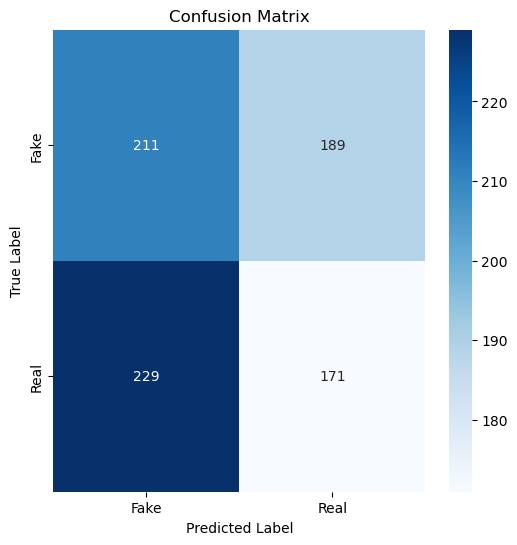

In [104]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a trained model and a test_generator for your dataset
# Make predictions for the test set
predictions = ela_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Convert the predictions to binary labels (0 or 1) using a threshold of 0.5
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Get the true labels from the test generator
true_labels = test_generator.classes

# Compute the confusion matrix using TensorFlow
conf_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a numpy array for better compatibility with plotting
conf_matrix = conf_matrix.numpy()

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

**Trained on images tested on ela**  
6/14 in ai      9/14 in real

ELA map saved: C:\Users\SWASTIK\anaconda3\envs\py37\projects\prnu_ela\ela_output\real13.jpeg
1/1 [==============================] - 0s 70ms/step
Prediction: Real (Class 1)


array([[1.]], dtype=float32)

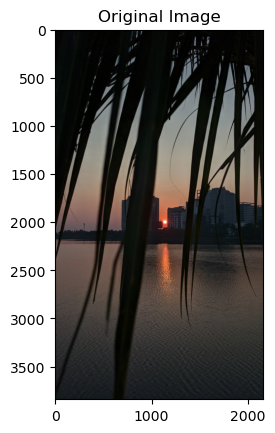

In [169]:
import tensorflow as tf
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to generate the ELA map
def generate_ela_map(input_path, output_path, jpeg_quality=95, amplify_factor=30):
    # Open the original image
    img = Image.open(input_path).convert('RGB')
    
    # Resize the image to 224x224
    img = img.resize((224, 224))
    
    # Save the original image as JPEG with the specified quality
    jpeg_path = 'temp_jpeg_image.jpg'
    img.save(jpeg_path, 'JPEG', quality=jpeg_quality)
    
    # Open the JPEG image (recompressed)
    jpeg_img = Image.open(jpeg_path)
    
    # Compute the ELA map by subtracting the original from the recompressed image
    ela_map = ImageChops.difference(img, jpeg_img)
    
    # Amplify the differences
    ela_map = ImageEnhance.Brightness(ela_map).enhance(amplify_factor)
    
    # Save the ELA map to the output directory
    ela_map.save(os.path.join(output_path, os.path.basename(input_path)))
    
    # Cleanup temporary JPEG file
    os.remove(jpeg_path)
    
    print(f"ELA map saved: {os.path.join(output_path, os.path.basename(input_path))}")

# Function to preprocess the image for model prediction
def preprocess_for_model(image_path):
    # Open the image
    img = Image.open(image_path).convert('RGB')
    
    # Resize the image to 224x224 (assuming your model was trained on 224x224)
    img = img.resize((224, 224))
    
    # Convert the image to numpy array
    img_array = np.array(img)
    
    # Normalize the image (assuming your model expects values between 0 and 1)
    img_array = img_array / 255.0
    
    # Expand dimensions to add batch size dimension (model expects shape: (batch_size, 224, 224, 3))
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

# Function to predict using the model
def predict_with_model(model, image_path):
    # Preprocess the image
    img_array = preprocess_for_model(image_path)
    
    # Predict with the model
    prediction = model.predict(img_array)
    
    # Assuming a binary classification, print the result
    if prediction[0][0] > 0.5:
        print("Prediction: Real (Class 1)")
    else:
        print("Prediction: Fake (Class 0)")
        
    return prediction

# Example usage
input_image_path = r"C:\Users\SWASTIK\anaconda3\envs\py37\projects\prnu_ela\real13.jpeg"  # Path to your input image
output_directory = r"C:\Users\SWASTIK\anaconda3\envs\py37\projects\prnu_ela\ela_output"  # Directory to save ELA map

# Generate the ELA map and save it
generate_ela_map(input_image_path, output_directory)

# Assuming `ela_model` is your trained model, load it (replace with your actual model loading method)
ela_model = tf.keras.models.load_model(r'C:\Users\SWASTIK\anaconda3\envs\py37\projects\prnu_ela\ela_tester.h5')

# Now pass the generated ELA map through the model
ela_map_path = os.path.join(output_directory, os.path.basename(input_image_path))  # Path to the generated ELA map

img = Image.open(input_image_path)
plt.imshow(img)
plt.title('Original Image')

# Predict using the trained model
predict_with_model(ela_model, ela_map_path)

**Trained on images Tested on images** 

13/14 on ai 3/14 on real

1/1 [==============================] - 0s 70ms/step
Prediction: Real (Class 1)


array([[1.]], dtype=float32)

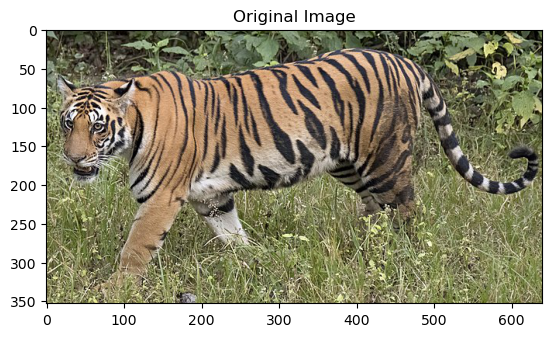

In [144]:
import tensorflow as tf
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to preprocess the image for model prediction
def preprocess_for_model(image_path):
    # Open the image
    img = Image.open(image_path).convert('RGB')
    
    # Resize the image to 224x224 (assuming your model was trained on 224x224)
    img = img.resize((224, 224))
    
    # Convert the image to numpy array
    img_array = np.array(img)
    
    # Normalize the image (assuming your model expects values between 0 and 1)
    img_array = img_array / 255.0
    
    # Expand dimensions to add batch size dimension (model expects shape: (batch_size, 224, 224, 3))
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

# Function to predict using the model
def predict_with_model(model, image_path):
    # Preprocess the image
    img_array = preprocess_for_model(image_path)
    
    # Predict with the model
    prediction = model.predict(img_array)
    
    # Assuming a binary classification, print the result
    if prediction[0][0] > 0.5:
        print("Prediction: Real (Class 1)")
    else:
        print("Prediction: Fake (Class 0)")
        
    return prediction

# Example usage
input_image_path = r"C:\Users\SWASTIK\anaconda3\envs\py37\projects\prnu_ela\real1.jpg"  # Path to your input image

# Assuming `ela_model` is your trained model, load it (replace with your actual model loading method)
ela_model = tf.keras.models.load_model(r'C:\Users\SWASTIK\anaconda3\envs\py37\projects\prnu_ela\ela_tester.h5')

img = Image.open(input_image_path)
plt.imshow(img)
plt.title('Original Image')

# Predict using the trained model
predict_with_model(ela_model, input_image_path)

**Testing on ELA_MAP**

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set the paths to your train and test datasets
train_dir = 'D:/downloads/ela_maps_split/train'
test_dir = 'D:/downloads/ela_maps_split/test'

# Set image size to match the input layer size (224x224)
image_size = (224, 224)

# Create ImageDataGenerators for data loading and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from directories with labels based on folder names (ai = 0, real = 1)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'  # For binary classification (real vs fake)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [11]:
ela_model = tf.keras.models.load_model(r'C:\Users\SWASTIK\anaconda3\envs\py37\projects\prnu_ela\ela_tester.h5')
# Evaluate the model on the test set
test_loss, test_acc = ela_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

25/25 [==============================] - 8s 297ms/step - loss: 6.3769 - accuracy: 0.7325
Test accuracy: 0.7325


In [12]:
# Evaluate the model on the train set
test_loss, test_acc = ela_model.evaluate(train_generator)
print(f'Test accuracy: {test_acc:.4f}')

100/100 [==============================] - 29s 285ms/step - loss: 7.0826 - accuracy: 0.7197
Test accuracy: 0.7197


25/25 [==============================] - 1s 52ms/step


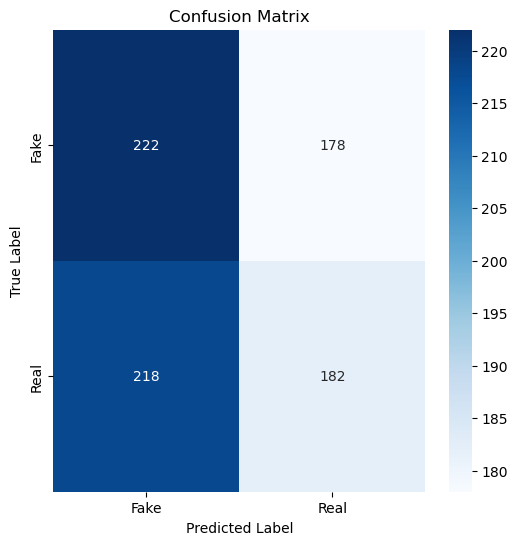

In [173]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a trained model and a test_generator for your dataset
# Make predictions for the test set
predictions = ela_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Convert the predictions to binary labels (0 or 1) using a threshold of 0.5
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Get the true labels from the test generator
true_labels = test_generator.classes

# Compute the confusion matrix using TensorFlow
conf_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a numpy array for better compatibility with plotting
conf_matrix = conf_matrix.numpy()

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()